In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os
import sys
import random
import seaborn as sns
from matplotlib.font_manager import FontProperties
font1 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=14)
font2 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=12)
font3 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=10)
font4 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=7)
sns.set_style('whitegrid')
sns.set_palette("muted")
random.seed(20241130)
np.random.seed(20241130)
torch.manual_seed(3407) # Torch.manual_seed(3407) is all you need. Paper: http://arxiv.org/abs/2109.08203
# 修改工作路径，使本.ipynb文件能够像在本文件夹根目录下一样导入其他模块
# Modify the working path so that this.ipynb file can import other modules like in the root directory
current_dir = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(current_dir, '..'))

In [2]:
df_whole=pd.read_excel("E:\\科创优才\\实验数据\\天然气锅炉数据1.xlsx", sheet_name="稳定运行数据段")
units=df_whole.iloc[0].tolist()
df=df_whole.iloc[2:].reset_index(drop=True)

# 重命名所有列名，缩短名称长度，方便使用
df.columns=[
    '开始时间',
    '主蒸汽流量计算值',
    '烟气含氧量（CEMS）',
    '颗粒浓度',
    '二氧化硫',
    'NO浓度',
    'NO2浓度',
    'NOX标干浓度',
    'NOX浓度',
    '烟气湿度（CEMS）',
    '烟气压力（CEMS）',
    '烟气温度（CEMS）',
    '一氧化碳',
    '锅炉天然气进气流量',
    '锅炉天然气进气温度',
    '锅炉天然气进气压力',
    '鼓风机出口温度',
    '鼓风机出口压力',
    '鼓风机变频器输出反馈',
    '鼓风机变频器电流反馈',
    '再循环烟气调节阀反馈',
    '冷凝器出口烟气调节阀反馈',
    '炉膛出口烟气温度（B分度）',
    '炉膛出口烟气压力',
    'SWY大气压',
    'SWY天气温度',
    'SWY空气湿度',
    'SWY湿球温度',
    '主蒸汽温度(蒸汽集箱出口温度）',
    '主蒸汽压力(蒸汽集箱出口压力）',
    '分汽缸温度',
    '分汽缸压力',
    '分汽缸出口至DN400蒸汽温度',
    '过热器集箱出口蒸汽温度',
    '天然气累计流量',
    '冷凝器烟气流量（累计值）',
    '冷凝器出口烟气流量',
    '冷凝器出口烟气温度'
]

# 将可能用到的变量名和单位存入字典
var_dict={
    "主蒸汽流量计算值": "t/h",
    "烟气含氧量（CEMS）": "mg/Nm3",
    "NO浓度": "mg/Nm3",
    "NO2浓度": "mg/Nm3",
    "NOX浓度": "mg/Nm3",
    "烟气湿度（CEMS）": "%",
    "烟气压力（CEMS）": "Pa",
    "烟气温度（CEMS）": "℃",
    "一氧化碳": "mg/Nm3",
    "锅炉天然气进气流量": "m3/h",
    "锅炉天然气进气温度": "℃",
    "锅炉天然气进气压力": "kPa",
    '鼓风机出口温度': "℃",
    "鼓风机出口压力": "kPa",
    "鼓风机变频器输出反馈": "Hz",
    "鼓风机变频器电流反馈": "A",
    "冷凝器出口烟气调节阀反馈": "%",
    "炉膛出口烟气压力": "Pa",
    "SWY大气压": "kPa",
    "SWY天气温度": "℃",
    "SWY空气湿度": "%",
    'SWY湿球温度': "℃",
    '主蒸汽温度(蒸汽集箱出口温度）': "℃",
    "主蒸汽压力(蒸汽集箱出口压力）": "MPa",
    "分汽缸温度": "℃",
    "分汽缸压力": "MPa",
    '分汽缸出口至DN400蒸汽温度': "℃",
    '过热器集箱出口蒸汽温度': "℃",
    "冷凝器出口烟气流量": "Nm3/h",
    "冷凝器出口烟气温度": "℃",
}
var_names=list(var_dict.keys())

# 定义输入变量
input_var_names=[
    "主蒸汽流量计算值",
    "锅炉天然气进气流量",
    "锅炉天然气进气温度",
    "锅炉天然气进气压力",
    '鼓风机出口温度',
    "鼓风机出口压力",
    "鼓风机变频器输出反馈",
    "鼓风机变频器电流反馈",
    "冷凝器出口烟气调节阀反馈",
    "SWY大气压",
    "SWY天气温度",
    "SWY空气湿度",
    'SWY湿球温度',
    "主蒸汽温度(蒸汽集箱出口温度）",
    "主蒸汽压力(蒸汽集箱出口压力）",
]

# 定义输出变量
output_var_names=[
    #"烟气含氧量（CEMS）",
    #NO浓度",
    #"NO2浓度", # 主要预测NO，因为NO2的准确性有待考量
    "NOX浓度",
    #"烟气湿度（CEMS）",
    #"烟气压力（CEMS）",
    #"烟气温度（CEMS）",
    #"一氧化碳",
    #"炉膛出口烟气压力",

    #暂时不考虑以下输出变量
    #"分汽缸温度",
    #"分汽缸压力",
    #"分汽缸出口至DN400蒸汽温度",
    #"过热器集箱出口蒸汽温度",
    #"冷凝器出口烟气流量",
    #"冷凝器出口烟气温度",
]

input_var_dict={name:var_dict[name] for name in input_var_names}
output_var_dict={name:var_dict[name] for name in output_var_names}

var_units=list(var_dict.values())
input_var_units=list(input_var_dict.values())
output_var_units=list(output_var_dict.values())

input_var_indices=[var_names.index(name) for name in input_var_names]
output_var_indices=[var_names.index(name) for name in output_var_names]


data_np=df[var_names].to_numpy(dtype=float)

'''
# 通过不同切片增加数据量
DATA=[
    data_np,
    data_np[:30,:],
    data_np[:50,:],
    data_np[:100,:],
    data_np[:800,:],
    data_np[100:850,:],
    data_np[200:900,:],
    data_np[300:950,:],
    data_np[400:1000,:],
    ]
'''
# 通过不同切片增加数据量
DATA=[
    data_np[:200,:],
    data_np[200:400,:],
    data_np[400:600,:],
    data_np[600:800,:],
    data_np[800:1000,:],
    data_np[1000:,:]
    ]


print("data_np.shape:", data_np.shape)

data_np.shape: (1124, 30)


In [3]:
# Hyperparameters
num_epochs = 100 # maximum number of epochs to train, if early stopping is not triggered
learning_rate = 0.001
input_len = 10
output_len = 1
overlap=1
label_len = 0 # label_len should be set only for decoder-based models, or there is potential risk of data leakage.
input_channels = len(input_var_names)
output_channels = len(output_var_names)
batch_size = 32
#device = 'cpu'  # 设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
from gas_data_prediction.data_preprocessing import GasData
DATASET=GasData(DATA,
                input_len=input_len,
                output_len=output_len,
                overlap=1,
                input_indices=input_var_indices,
                output_indices=output_var_indices,
                var_names=var_names,
                var_units=var_units)
transformed_data, \
    (var_mean, var_std_dev), \
    (input_var_mean, input_var_std_dev), \
    (output_var_mean, output_var_std_dev) \
        = DATASET.standardize()
DATASET.train_test_split()
(X_train_grouped, Y_train_grouped), (X_test_grouped, Y_test_grouped) = DATASET.time_series_slice()
(X_train, Y_train), (X_test, Y_test) = DATASET.build_train_test_set()


var_mean.shape:  (30,)
var_std_dev.shape:  (30,)
var_mean: [ 2.02454448e+01  5.38171708e+00  1.15021619e+01  1.51783808e+00
  1.30202135e+01  6.11244662e+00 -2.59562011e+01  4.89649911e+01
  2.41827402e+00  1.33189771e+03  1.32355694e+01  4.68861299e+01
  3.83970196e+01  4.53386121e+00  3.50048043e+01  1.52158390e+02
  1.00035721e+02  1.25514235e+00  9.55486655e+01  6.49555160e+00
  8.72197509e+01  5.42132562e+00  2.38364822e+02  8.01058719e-01
  2.54781183e+02  7.57793594e-01  2.62174084e+02  2.16910721e+02
  1.73719840e+01  4.68721263e+01]
var_std_dev: [5.30066771e+00 1.11696693e+00 2.86279569e+00 1.76971041e+00
 3.38589677e+00 8.14333762e-01 6.97501561e+00 2.75123054e+00
 1.39755026e+01 3.46893122e+02 1.08214658e+00 6.40227151e-01
 1.94536394e+00 6.69420689e-01 3.40721652e+00 3.14428900e+01
 1.28125092e-02 7.54971116e-01 1.91333581e-01 1.88385578e+00
 1.53245065e+01 1.03582489e+00 6.61709770e+00 4.04142267e-02
 6.78732161e+00 3.81667081e-02 6.72964314e+00 5.08419020e+00
 2.48901418e

In [14]:
from models.RNN import RNN, LSTM, GRU
from models.CNN import CNN, TCN
from models.MLP import MLP
from models.transformer import Transformer, iTransformer, PatchTST, Reformer, Informer
from models.Linear import LLinear, DLinear, NLinear
from models.stat import Identical, ExponentialMovingAverage, SVR
from gas_data_prediction.utils import FitHistory



# Instantiate models, loss functions, evaluation functions, and optimizers
# 实例化模型、损失函数、评估函数和优化器
MODEL = MLP(
    input_len=input_len, output_len=output_len, input_channels=input_channels, output_channels=output_channels,
    ).to(device)
loss_func = nn.MSELoss()
metric_func=nn.L1Loss()
optimizer = optim.Adam(MODEL.parameters(), lr=learning_rate)
history=FitHistory()
print('Model parameters: ', sum(p.numel() for p in MODEL.parameters()))

Model parameters:  46945


In [15]:
from gas_data_prediction.data_preprocessing import get_XY_loaders
train_loader, val_loader, test_loader = get_XY_loaders(X_train, Y_train, batch_size=batch_size)

Train dataset size: X: (478, 10, 15); Y: (478, 1, 1)
Val dataset size: X: (68, 10, 15); Y: (68, 1, 1)
Test dataset size: X: (136, 10, 15); Y: (136, 1, 1)


In [16]:
Y_test.shape

(380, 1, 1)

  4%|▍         | 4/100 [00:00<00:05, 16.51it/s]

Epoch [ 1  /100], Time: 0.0743s, Loss: 0.8197, Metric: 0.7321, Val Loss: 0.8000, Val Metric: 0.7570
Epoch [ 2  /100], Time: 0.0599s, Loss: 0.5571, Metric: 0.5914, Val Loss: 0.5453, Val Metric: 0.6206
Epoch [ 3  /100], Time: 0.0533s, Loss: 0.4681, Metric: 0.5371, Val Loss: 0.4339, Val Metric: 0.5228
Epoch [ 4  /100], Time: 0.0587s, Loss: 0.4074, Metric: 0.4869, Val Loss: 0.3086, Val Metric: 0.4826


  9%|▉         | 9/100 [00:00<00:04, 19.79it/s]

Epoch [ 5  /100], Time: 0.0625s, Loss: 0.3289, Metric: 0.4267, Val Loss: 0.2699, Val Metric: 0.4453
Epoch [ 6  /100], Time: 0.0467s, Loss: 0.3399, Metric: 0.4375, Val Loss: 0.2296, Val Metric: 0.3811
Epoch [ 7  /100], Time: 0.0428s, Loss: 0.2815, Metric: 0.3920, Val Loss: 0.1943, Val Metric: 0.3093
Epoch [ 8  /100], Time: 0.0418s, Loss: 0.2763, Metric: 0.3862, Val Loss: 0.1982, Val Metric: 0.3493
Epoch [ 9  /100], Time: 0.0417s, Loss: 0.2331, Metric: 0.3570, Val Loss: 0.1704, Val Metric: 0.3254


 15%|█▌        | 15/100 [00:00<00:03, 21.59it/s]

Epoch [ 10 /100], Time: 0.0478s, Loss: 0.2415, Metric: 0.3467, Val Loss: 0.2389, Val Metric: 0.3736
Epoch [ 11 /100], Time: 0.0429s, Loss: 0.2349, Metric: 0.3519, Val Loss: 0.2431, Val Metric: 0.3836
Epoch [ 12 /100], Time: 0.0382s, Loss: 0.2056, Metric: 0.3253, Val Loss: 0.1969, Val Metric: 0.3352
Epoch [ 13 /100], Time: 0.0439s, Loss: 0.2040, Metric: 0.3151, Val Loss: 0.1682, Val Metric: 0.3386
Epoch [ 14 /100], Time: 0.0415s, Loss: 0.1770, Metric: 0.2987, Val Loss: 0.1810, Val Metric: 0.3281
Epoch [ 15 /100], Time: 0.0456s, Loss: 0.1895, Metric: 0.3088, Val Loss: 0.1467, Val Metric: 0.3079


 18%|█▊        | 18/100 [00:00<00:03, 21.09it/s]

Epoch [ 16 /100], Time: 0.0535s, Loss: 0.1809, Metric: 0.3117, Val Loss: 0.2005, Val Metric: 0.3359
Epoch [ 17 /100], Time: 0.0453s, Loss: 0.1524, Metric: 0.2791, Val Loss: 0.1272, Val Metric: 0.2685
Epoch [ 18 /100], Time: 0.0486s, Loss: 0.1629, Metric: 0.2797, Val Loss: 0.1916, Val Metric: 0.3315
Epoch [ 19 /100], Time: 0.0465s, Loss: 0.1496, Metric: 0.2739, Val Loss: 0.1717, Val Metric: 0.3147
Epoch [ 20 /100], Time: 0.0408s, Loss: 0.1614, Metric: 0.2861, Val Loss: 0.1364, Val Metric: 0.3010


 24%|██▍       | 24/100 [00:01<00:03, 22.08it/s]

Epoch [ 21 /100], Time: 0.0426s, Loss: 0.1495, Metric: 0.2722, Val Loss: 0.2561, Val Metric: 0.3832
Epoch [ 22 /100], Time: 0.0433s, Loss: 0.1421, Metric: 0.2730, Val Loss: 0.1266, Val Metric: 0.2855
Epoch [ 23 /100], Time: 0.0442s, Loss: 0.1405, Metric: 0.2678, Val Loss: 0.1386, Val Metric: 0.2958
Epoch [ 24 /100], Time: 0.0427s, Loss: 0.1375, Metric: 0.2681, Val Loss: 0.1651, Val Metric: 0.3252
Epoch [ 25 /100], Time: 0.0479s, Loss: 0.1230, Metric: 0.2532, Val Loss: 0.2408, Val Metric: 0.3643


 30%|███       | 30/100 [00:01<00:03, 21.79it/s]

Epoch [ 26 /100], Time: 0.0463s, Loss: 0.1316, Metric: 0.2641, Val Loss: 0.1801, Val Metric: 0.3331
Epoch [ 27 /100], Time: 0.0463s, Loss: 0.1479, Metric: 0.2719, Val Loss: 0.1877, Val Metric: 0.3367
Epoch [ 28 /100], Time: 0.0436s, Loss: 0.1308, Metric: 0.2644, Val Loss: 0.1217, Val Metric: 0.2774
Epoch [ 29 /100], Time: 0.0469s, Loss: 0.1246, Metric: 0.2566, Val Loss: 0.1396, Val Metric: 0.3014
Epoch [ 30 /100], Time: 0.0456s, Loss: 0.1244, Metric: 0.2517, Val Loss: 0.2081, Val Metric: 0.3392


 33%|███▎      | 33/100 [00:01<00:03, 21.89it/s]

Epoch [ 31 /100], Time: 0.0494s, Loss: 0.1127, Metric: 0.2415, Val Loss: 0.1305, Val Metric: 0.2883
Epoch [ 32 /100], Time: 0.0420s, Loss: 0.1233, Metric: 0.2477, Val Loss: 0.1718, Val Metric: 0.3096
Epoch [ 33 /100], Time: 0.0421s, Loss: 0.1143, Metric: 0.2434, Val Loss: 0.3012, Val Metric: 0.4351
Epoch [ 34 /100], Time: 0.0462s, Loss: 0.1093, Metric: 0.2382, Val Loss: 0.2520, Val Metric: 0.3787
Epoch [ 35 /100], Time: 0.0462s, Loss: 0.1096, Metric: 0.2373, Val Loss: 0.1367, Val Metric: 0.2728


 39%|███▉      | 39/100 [00:01<00:02, 21.89it/s]

Epoch [ 36 /100], Time: 0.0444s, Loss: 0.1223, Metric: 0.2440, Val Loss: 0.1465, Val Metric: 0.3021
Epoch [ 37 /100], Time: 0.0468s, Loss: 0.1064, Metric: 0.2309, Val Loss: 0.1872, Val Metric: 0.3327
Epoch [ 38 /100], Time: 0.0460s, Loss: 0.1108, Metric: 0.2325, Val Loss: 0.1249, Val Metric: 0.2524
Epoch [ 39 /100], Time: 0.0426s, Loss: 0.1079, Metric: 0.2341, Val Loss: 0.1397, Val Metric: 0.2892
Epoch [ 40 /100], Time: 0.0502s, Loss: 0.0925, Metric: 0.2067, Val Loss: 0.1168, Val Metric: 0.2415


 40%|████      | 40/100 [00:01<00:02, 20.60it/s]


Epoch [ 41 /100], Time: 0.0459s, Loss: 0.0969, Metric: 0.2138, Val Loss: 0.1875, Val Metric: 0.3300
Early stopping at epoch 41.
Total Time: 1.9275s


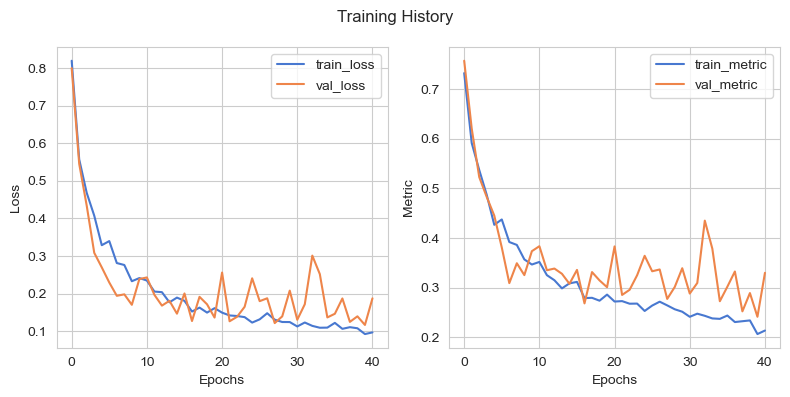

Number of epochs:  41
Training time:     1.9275s
Training loss:     0.0969
Training metric:   0.2138
Validation loss:   0.1875
Validation metric: 0.3300
Loss on test set:  0.7599853277206421


In [17]:
from gas_data_prediction.utils import train
# train the model
history.update(
            *train(MODEL, train_loader, val_loader, optimizer,
                loss_func=nn.MSELoss(),
                metric_func=nn.L1Loss(),
                num_epochs=num_epochs,
                device=device,
                verbose=1)
            )
history.plot()
history.summary()
print("Loss on test set: ", MODEL.evaluate((X_test, Y_test),mode="numpy",device=device))


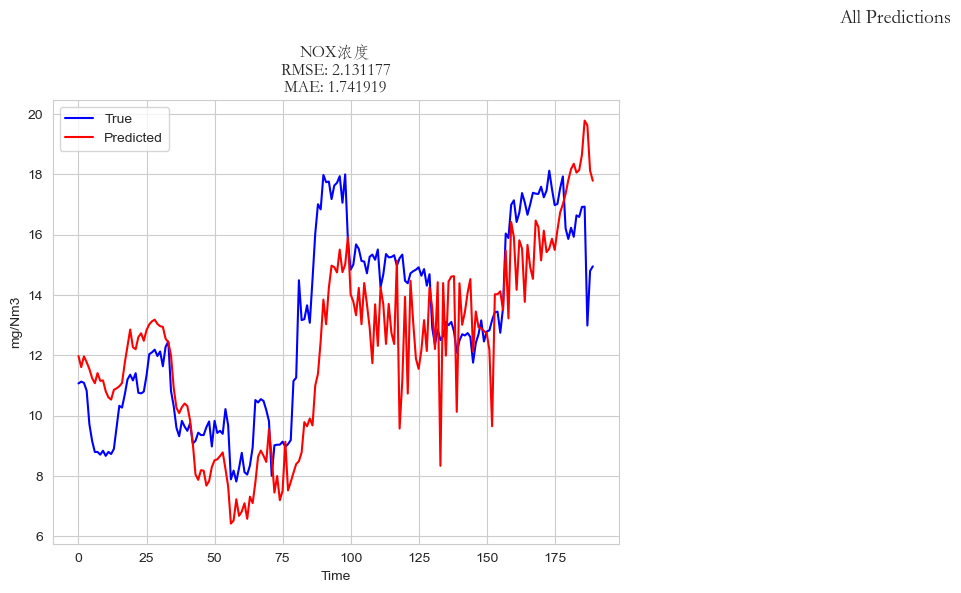

In [18]:
from gas_data_prediction.utils import ModelTest
Exp=ModelTest(MODEL, DATASET, device=device) # Experiment object initialization
Y_pred, Y_true = Exp.get_pred_true_pairs(X_test_grouped[1], Y_test_grouped[1], with_Tensor=True)
Exp.plot_all_predictions(Y_pred, Y_true, plot_residual=0, rescale=1, figsize=(18, 6))

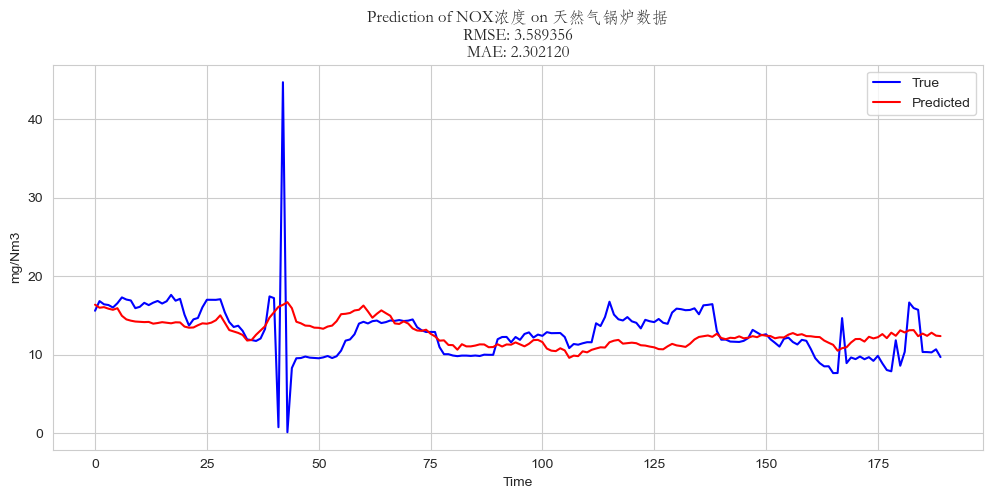

In [19]:
# Visualize on a particular variable and particular file
from gas_data_prediction.utils import visualize_var

var_idx=0
data_idx=0

Y_pred, Y_true=Exp.get_pred_true_pairs(X_test_grouped[data_idx],Y_test_grouped[data_idx], with_Tensor=True)

#Y_pred, Y_true=Exp.get_pred_true_pairs(X_train_grouped[data_idx],Y_train_grouped[data_idx], with_Tensor=True)


shared_params={
    'Y_pred': Y_pred,
    'Y_true': Y_true,
    'var_idx': var_idx,
    'var_names': output_var_names,
    'var_units': output_var_units,
    'data_name': "天然气锅炉数据",
    'var_mean': output_var_mean,
    'var_std_dev': output_var_std_dev,
}


visualize_var(**shared_params, plot_residual=0, rescale=1)

In [20]:
Exp.get_prediction_info(X_test_grouped,Y_test_grouped,with_Tensor=True)

,unit,RMSE,RMSE_rescaled,MAE,MAE_rescaled
NOX浓度,mg/Nm3,0.871771,2.951728,0.597189,2.02202
